In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)


aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

# Somehow 5s_CTC is not accepted by statsmodels for the linear mixed model... (doesn't like variables that start with numbers)
aclew_measures = aclew_measures.rename(columns={'5s_CTC': 'CTC', 'wc_adu': 'AWC'})
lena_measures = lena_measures.rename(columns={'5s_CTC': 'CTC', 'wc_adu': 'AWC'})
human_measures = human_measures.rename(columns={'5s_CTC': 'CTC', 'wc_adu': 'AWC'})

print(human_measures.groupby('group_id').size())
print(f"Total = {human_measures.groupby('group_id').size().sum()}")


group_id
angelman_syndrome     99
autism_sibling        45
down_syndrome         75
fragile_x_syndrome    90
low_risk              75
dtype: int64
Total = 384


In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

def print_full_mixed_effects_results(human_measures, automatic_measures, dvs):
    """
    Print mixed effects results table for multiple dependent variables.
    """
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    data = pd.merge(
        human_measures, 
        automatic_measures,
        on=['recording_filename', 'segment_onset', 'segment_offset', 'child_id', 'group_id', 'child_sex', 'age'],
        suffixes=('_estimated', '_true')
    ) 

    data['group_id'] = data['group_id'].replace({
        'low_risk': '_low_risk',
        'angelman_syndrome': 'angelman_syndrome',
        'autism_sibling': 'autism_sibling',
        'down_syndrome': 'down_syndrome',
        'fragile_x_syndrome': 'fragile_x_syndrome'
    })
    print("\nTable X. Mixed Effects Analysis Results")
    print("-" * 80)
    print(f"{'Dependent Variable':<20} {'Predictor':<20} {'z':>8} {'p':>10} {'η²p':>8}")
    print("-" * 80)
    
    for dv in dvs:
        # Fit model
        model = smf.mixedlm(
            f"{dv}_true ~ {dv}_estimated + group_id + age + child_sex", 
            data=data,
            groups="child_id"
        ).fit()
        
        # Get results table
        results = model.summary().tables[1]
        
        # Process results (skip the last row which is for random effects)
        for idx in range(len(results)-1):
            name = results.index[idx]
            z_stat = float(results.iloc[idx, 2])
            p_val = float(results.iloc[idx, 3])
            
            # Clean up predictor names
            clean_name = (name.replace('group_id[T.', '')
                            .replace('child_sex[T.', '')
                            .replace(']', '')
                            .replace('_', ' '))
            
            # Calculate partial eta-squared
            df_resid = model.df_resid
            eta_sq = (z_stat**2) / (z_stat**2 + df_resid)
            
            # Format p-value
            if p_val < 0.001:
                p_value = "< .001***"
            else:
                p_value = f"{p_val:.3f}"
                if p_val < 0.01:
                    p_value += "**"
                elif p_val < 0.05:
                    p_value += "*"
            
            print(f"{dv:<20} {clean_name:<20} {z_stat:>8.2f} {p_value:>10} {eta_sq:>8.3f}")
        
        print()
    
    print("-" * 80)
    print("Note: η²p = partial eta-squared")
    print("* p < .05, ** p < .01, *** p < .001")

# Example usage:
dvs = ['CTC', 'CVC', 'AWC']
print('LENA')
print_full_mixed_effects_results(human_measures, lena_measures, dvs)
print('ACLEW')
print_full_mixed_effects_results(human_measures, aclew_measures, dvs)

LENA

Table X. Mixed Effects Analysis Results
--------------------------------------------------------------------------------
Dependent Variable   Predictor                   z          p      η²p
--------------------------------------------------------------------------------
CTC                  Intercept                1.26      0.208    0.004
CTC                  angelman syndrome        0.88      0.377    0.002
CTC                  autism sibling           0.03      0.976    0.000
CTC                  down syndrome            0.66      0.512    0.001
CTC                  fragile x syndrome       0.77      0.441    0.002
CTC                  m                       -0.54      0.590    0.001
CTC                  CTC estimated           20.00  < .001***    0.516
CTC                  age                     -1.15      0.250    0.004

CVC                  Intercept                1.44      0.149    0.006
CVC                  angelman syndrome        0.09      0.931    0.000
CVC       

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def add_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

param_name = {
    'group_id[T.angelman_syndrome]': 'Angelman',
    'group_id[T.autism_sibling]': 'Autism sib.',
    'group_id[T.down_syndrome]': 'Down',
    'group_id[T.fragile_x_syndrome]': 'Fragile X',
    'CVC_estimated': 'CVC_estimated',
    'CTC_5s': 'CTC_estimated',
    'wc_adu_estimated': 'AWC_estimated',
    'age': 'age',
    'child_id': 'child_id'

}

def biases_mixed_model(hyp, ref, measure):
    merged_data = pd.merge(
        hyp, 
        ref, 
        on=['recording_filename', 'segment_onset', 'segment_offset', 'child_id', 'group_id', 'age'],
        suffixes=('_estimated', '_true')
    ) 
    
    # Merge the data
    merged_data['group_id'] = merged_data['group_id'].replace({
        'low_risk': '_low_risk',
        'angelman_syndrome': 'angelman_syndrome',
        'autism_sibling': 'autism_sibling',
        'down_syndrome': 'down_syndrome',
        'fragile_x_syndrome': 'fragile_x_syndrome'
    })

    # Fit the mixed-effects model
    # Note: Changed the formula to match your variables but kept true as dependent variable
    model = smf.mixedlm(
        f"{measure}_true ~ {measure}_estimated + group_id + age", 
        data=merged_data,
        groups="child_id"
    )

    result = model.fit()
    conf_int = result.conf_int()
    #print(result.summary())
    print("\nFixed Effects with 95% Confidence Intervals:")
    print("Parameter Estimate CI_lower CI_upper p-value Significance")
    for param in result.params.index:
        # Get significance stars
        p_value = result.pvalues[param]
        stars = ''
        if p_value < 0.001:
            stars = '***'
        elif p_value < 0.01:
            stars = '**'
        elif p_value < 0.05:
            stars = '*'

        param_label = param
        if param in param_name:
            param_label = param_name[param]
        print(f"{param_label} {result.params[param]:.2f} {conf_int.loc[param][0]:.2f} {conf_int.loc[param][1]:.2f} {p_value:.3f} {stars}")

print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='CVC')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='CVC')

ACLEW

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -1.25 -5.38 2.87 0.552 
Angelman -1.51 -3.75 0.74 0.188 
Autism sib. 1.52 -1.24 4.29 0.281 
Down -1.17 -3.65 1.30 0.352 
Fragile X -1.22 -3.53 1.09 0.300 
CVC_estimated 1.33 1.23 1.44 0.000 ***
age 0.14 -0.05 0.33 0.157 
child_id Var 0.03 -0.03 0.08 0.405 


LENA

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -2.04 -7.73 3.64 0.481 
Angelman -1.11 -4.19 1.98 0.482 
Autism sib. 0.70 -3.12 4.52 0.721 
Down 1.82 -1.59 5.23 0.296 
Fragile X -0.62 -3.81 2.57 0.702 
CVC_estimated 1.31 1.20 1.41 0.000 ***
age 0.25 -0.01 0.51 0.061 
child_id Var 0.11 -0.01 0.22 0.061 


In [14]:
print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='wc_adu')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='wc_adu')

ACLEW


PatsyError: Error evaluating factor: NameError: name 'wc_adu_true' is not defined
    wc_adu_true ~ wc_adu_estimated + group_id + age
    ^^^^^^^^^^^

In [4]:
print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='CTC_5s')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='CTC_5s')

ACLEW

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -0.48 -3.34 2.38 0.743 
Angelman -0.42 -1.98 1.14 0.596 
Autism sib. 0.81 -1.11 2.73 0.408 
Down -1.47 -3.19 0.25 0.093 
Fragile X -0.99 -2.60 0.61 0.224 
CTC_5s_estimated 1.00 0.94 1.07 0.000 ***
age 0.04 -0.09 0.17 0.569 
child_id Var 0.00 -0.05 0.05 0.915 


LENA

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -1.40 -6.73 3.94 0.607 
Angelman -1.60 -4.50 1.29 0.277 
Autism sib. 0.62 -2.96 4.20 0.735 
Down -0.85 -4.04 2.35 0.604 
Fragile X -1.24 -4.23 1.75 0.415 
CTC_5s_estimated 2.98 2.70 3.27 0.000 ***
age 0.20 -0.04 0.45 0.103 
child_id Var 0.10 -0.01 0.20 0.075 


In [5]:
# Running analyses, removing clips without child speech
mask = (human_measures.voc_dur_chi != 0) & (human_measures.wc_adu != 0)
human_measures = human_measures[mask]
lena_measures = lena_measures[mask]
aclew_measures = aclew_measures[mask]

print(human_measures.groupby('group_id').size())
print(f"Total = {human_measures.groupby('group_id').size().sum()}")

print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='CVC')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='CVC')

print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='wc_adu')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='wc_adu')

print("ACLEW")
biases_mixed_model(aclew_measures, human_measures, measure='CTC_5s')
print("\n\nLENA")
biases_mixed_model(lena_measures, human_measures, measure='CTC_5s')

group_id
angelman_syndrome     56
autism_sibling        28
down_syndrome         57
fragile_x_syndrome    50
low_risk              37
dtype: int64
Total = 228
ACLEW


/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conve


Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -0.88 -7.76 6.00 0.801 
Angelman -2.24 -6.09 1.61 0.253 
Autism sib. 2.30 -2.29 6.90 0.326 
Down -3.07 -7.07 0.94 0.134 
Fragile X -1.59 -5.54 2.35 0.429 
CVC_estimated 1.17 1.00 1.34 0.000 ***
age 0.26 -0.04 0.56 0.095 
child_id Var 0.09 -0.05 0.24 0.196 


LENA

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept -0.88 -9.16 7.40 0.834 
Angelman -2.58 -7.14 1.98 0.268 
Autism sib. 1.39 -4.16 6.95 0.623 
Down -0.55 -5.47 4.36 0.825 
Fragile X -0.78 -5.51 3.94 0.745 
CVC_estimated 1.07 0.94 1.20 0.000 ***
age 0.38 0.01 0.75 0.043 *
child_id Var 0.27 0.02 0.52 0.033 *
ACLEW


/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conve


Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept 30.85 -14.34 76.03 0.181 
Angelman -21.90 -47.17 3.36 0.089 
Autism sib. -23.88 -54.45 6.69 0.126 
Down -15.17 -41.91 11.57 0.266 
Fragile X -24.50 -50.71 1.71 0.067 
AWC_estimated 0.70 0.63 0.78 0.000 ***
age -0.27 -2.26 1.72 0.792 
child_id Var 0.14 -0.19 0.47 0.398 


LENA


/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept 21.32 -24.49 67.13 0.362 
Angelman -16.17 -41.74 9.40 0.215 
Autism sib. -19.89 -50.81 11.02 0.207 
Down -9.76 -36.87 17.34 0.480 
Fragile X -28.50 -55.16 -1.84 0.036 *
AWC_estimated 0.98 0.87 1.09 0.000 ***
age 1.08 -0.94 3.10 0.295 
child_id Var 0.14 -0.18 0.45 0.391 
ACLEW


/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/engaclew/miniconda3/envs/neurogen/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conve


Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept 0.13 -5.93 6.18 0.967 
Angelman -0.33 -3.67 3.00 0.844 
Autism sib. 1.94 -2.07 5.96 0.343 
Down -2.27 -5.77 1.23 0.204 
Fragile X -1.32 -4.76 2.11 0.450 
CTC_5s_estimated 1.01 0.91 1.11 0.000 ***
age 0.04 -0.23 0.30 0.784 
child_id Var 0.12 -0.14 0.38 0.378 


LENA

Fixed Effects with 95% Confidence Intervals:
Parameter Estimate CI_lower CI_upper p-value Significance
Intercept 2.40 -6.26 11.05 0.587 
Angelman -3.32 -8.08 1.44 0.171 
Autism sib. 0.17 -5.64 5.97 0.956 
Down -2.78 -7.88 2.31 0.284 
Fragile X -2.21 -7.15 2.73 0.380 
CTC_5s_estimated 2.69 2.30 3.08 0.000 ***
age 0.19 -0.20 0.57 0.344 
child_id Var 0.21 -0.01 0.43 0.063 


In [45]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', '1s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)
# LENA already has CVC

def group_data(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    data = data.groupby('recording_filename').agg({
        '5s_CTC': np.sum,
        '1s_CTC': np.sum,
        'voc_dur_chi': np.sum,
        'voc_chi': np.sum,
        'wc_adu': np.sum,
        'CVC': np.sum,
        'group_id': 'first',
        'child_id': 'first'
    }).reset_index()
    return data

aclew_measures = group_data(aclew_measures)
lena_measures = group_data(lena_measures)
human_measures = group_data(human_measures)

/tmp/ipykernel_26269/3860198566.py:35: FutureWarning: The provided callable <function sum at 0x74af341baf80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_26269/3860198566.py:35: FutureWarning: The provided callable <function sum at 0x74af341baf80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_26269/3860198566.py:35: FutureWarning: The provided callable <function sum at 0x74af341baf80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykerne

In [46]:
from scipy import stats

def compute_me(x, y):
    """ Compute mean error """
    me_list = (x-y).values
    return me_list

def compute_mpe(x, y):
    """ Compute mean error """
    errors = np.zeros_like(x, dtype=float)
    # Case 1: y != 0 - standard MPE calculation
    mask_nonzero = (y != 0)
    errors[mask_nonzero] = (x[mask_nonzero] - y[mask_nonzero]) / y[mask_nonzero]
    # Case 2: y = 0 and x != 0 -> error = 1
    mask_zero_error = (y == 0) & (x != 0)
    errors[mask_zero_error] = 1
    # Case 3: y = 0 and x = 0 -> error = 0 is already handled by initialization
    return 100*errors


columns = ['group_id', '5s_CTC', '1s_CTC', 'voc_dur_chi', 'voc_chi', 'wc_adu', 'CVC']
lena_scores, aclew_scores = {}, {}
print("Computing on %d chunks." % len(human_measures))
for col in columns:
    if col == 'group_id':
        lena_scores[col] = lena_measures[col].values
        aclew_scores[col] = aclew_measures[col].values
        continue
        
    if col == 'voc_dur_chi':
        lena_measures[col] /= 1000
        aclew_measures[col] /= 1000
        human_measures[col] /= 1000

    groups =  human_measures['group_id'].values
    # Compute LENA
    lena_pearson_r = compute_pearson(lena_measures[col], human_measures[col])
    lena_group_pearson_r = compute_group_pearson(lena_measures[col], human_measures[col], groups)
    lena_me_list = compute_me(lena_measures[col], human_measures[col])
    lena_mpe_list = compute_mpe(lena_measures[col], human_measures[col])

    # Compute ACLEW
    aclew_pearson_r = compute_pearson(aclew_measures[col], human_measures[col])
    aclew_group_pearson_r = compute_group_pearson(aclew_measures[col], human_measures[col], groups)
    aclew_me_list = compute_me(aclew_measures[col], human_measures[col])
    aclew_mpe_list = compute_mpe(aclew_measures[col], human_measures[col])
    lena_scores[col] = {
        'me_list': lena_me_list,
        'mpe_list': lena_mpe_list,
        }
    aclew_scores[col] = {
        'me_list': aclew_me_list,
        'mpe_list': aclew_mpe_list,
        }

Computing on 26 chunks.


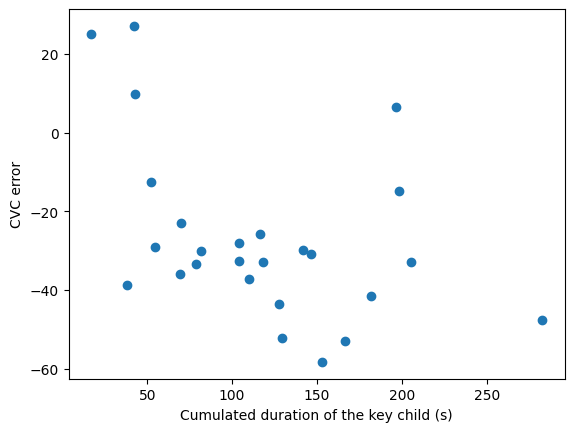

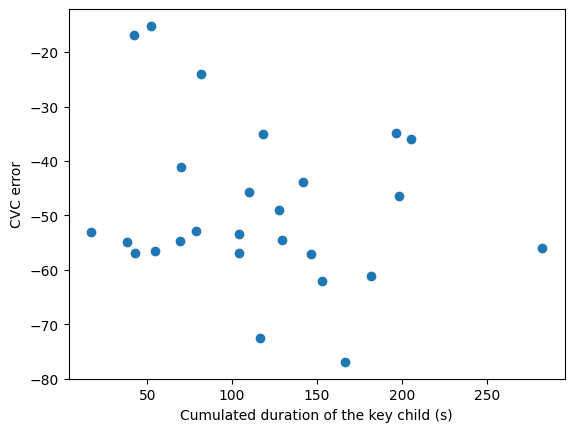

In [59]:
cum_dur_per_child = human_measures.groupby('recording_filename').agg({
    'voc_dur_chi': 'sum',
    'group_id': 'first'  # Since there's only one group_id per recording
})

plt.scatter(cum_dur_per_child['voc_dur_chi'], aclew_scores['CVC']['mpe_list'])
plt.xlabel('Cumulated duration of the key child (s)') 
plt.ylabel('CVC error')
plt.show()

plt.scatter(cum_dur_per_child['voc_dur_chi'], lena_scores['CVC']['mpe_list'])
plt.xlabel('Cumulated duration of the key child (s)') 
plt.ylabel('CVC error')
plt.show()